In [109]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import subprocess
from help.parser import parser, make_scale_fn, train_test_split
#from help.lstm import BasicLSTM
import numpy as np

import matplotlib.pyplot as plt
from help.plot_confusion_matrix import plot_confusion_matrix

from sklearn.metrics import confusion_matrix

In [6]:
###  STEP 9 ###
dir = './recordings/'
X_train, X_test, Y_train, Y_test, spk_train, spk_test = parser(dir)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.2)
print("using all data to calculate normalization statistics")
scale_fn = make_scale_fn(X_train + X_dev + X_test)
 
X_train = scale_fn(X_train)
X_dev = scale_fn(X_dev)
X_test = scale_fn(X_test)
    
print(f"\nSize of first sample {X_train[0].shape}\n")

print(f"Test size {len(Y_test)}")
print(f"Dev size {len(Y_dev)}")
print(f"Train size {len(Y_train)}")


Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:13<00:00, 229.50it/s]


Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split
using all data to calculate normalization statistics
Normalization will be performed using mean: [-517.82970101   62.38579548   18.8177718     9.58994408  -19.21332918
  -10.90544171]
Normalization will be performed using std: [152.29960089  51.98705829  36.71929112  29.63888662  24.80403286
  23.39483935]

Size of first sample (28, 6)

Test size 300
Dev size 540
Train size 2160


In [96]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
from help.parser import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class EarlyStopping(object):
    def __init__(self,model,save_dir, patience, mode="min", base=None):
        self.best = base
        self.patience = patience
        self.patience_left = patience
        self.mode = mode
        self.model = model
        self.save_dir = save_dir

    def stop(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Decrease patience if the metric hs not improved
        # Stop when patience reaches zero
        
        ## checkpoint and early stopping implementation
        if self.best == None:    ## first epoch
            self.best = value 
            torch.save((self.model).state_dict(),self.save_dir)
            
        elif self.best < value: ## if error increases, decreace patience
            self.patience_left -= 1
        elif self.best > value: ## if error decreases, restart patience with new error, resave best params
            self.best = value
            self.patience_left = self.patience
            torch.save((self.model).state_dict(),self.save_dir)
            
        return self.patience_left == 0

    def has_improved(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Check if the metric has improved
        return self.best < value

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
        feats: Python list of numpy arrays that contain the sequence features.
               Each element of this list is a numpy array of shape seq_length x feature_dimension
        labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        # TODO: YOUR CODE HERE
        self.lengths = [len(i) for i in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype("int64")

    def zero_pad_and_stack(self, x: np.ndarray) -> np.ndarray:
        """
        This function performs zero padding on a list of features and forms them into a numpy 3D array
        returns
            padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #
        max_len = max(self.lengths) ## max sequence length
        ## stack zeros np.array of shape (maxlen - seqlen x feature len) at the end of each seq array (axis 0)
        padded = np.array([np.concatenate((seq,np.zeros((max_len-seq.shape[0],seq.shape[1]))),axis=0) for seq in x],dtype=np.float32)  
        
        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)


class BasicLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size,
        output_dim,
        num_layers,
        bidirectional=False,
        dropout=0.0,
    ):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size*2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        ## the lstm part
        self.lstm = nn.LSTM(input_size=self.input_dim,hidden_size=self.feature_size,
                            num_layers=self.num_layers,bidirectional=self.bidirectional,
                            dropout=self.dropout,batch_first=True)
        
        ## the  output part
        self.hidden2out_dim = 2*self.feature_size if self.bidirectional else self.feature_size
        self.output = nn.Linear(in_features=self.hidden2out_dim,out_features=self.output_dim)
        

    def forward(self, x, lengths):
        """
        x : 3D numpy array of dimension N x L x D
            N: batch index
            L: sequence index
            D: feature index

        lengths: N x 1
        """
        # --------------- Insert your code here ---------------- #

        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        dim = 2*self.num_layers if self.bidirectional else self.num_layers ## determines 1st dim of h0,c0
        
        h0 = torch.zeros(dim,x.size(0),self.feature_size) ## batched input
        c0 = torch.zeros(dim,x.size(0),self.feature_size)
        out, _ = self.lstm(x,(h0,c0))
        last_steps = self.last_timestep(outputs=out,lengths=lengths,bidirectional=self.bidirectional)
        
        last_outputs = self.output(last_steps)
        return last_outputs ## size: (N,output dim)

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
        Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs) ## get the seperate vectors
            last_forward = self.last_by_index(forward, lengths) ## for forward use last_by_index to get last
            last_backward = backward[:, 0, :] ## in backwards the first is the last
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        '''
        Splits outputs vectors to forward and backward part
        '''
        direction_size = int(outputs.size(-1) / 2) ## forward and backward have the half len of outputs
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        '''
        Extract the last relevant output from a sequnence of ouputs using 
        the provided lenghts.
        
        outputs: (N,L,D) = (batch, sequence, feature) sizes.
        lenghts: Nx1
        
        '''
        # Index of the last output for each sequence.
        idx = (
            (lengths - 1) ## get the index of the last item for each sequence in outputs (turn lenghts from values to indexes of said values)
            .view(-1, 1)  ## reshape tensor into col vector
            .expand(outputs.size(0), outputs.size(2)) ## broadcast the vector to batch dim (0) and feature dim (2) -> create matrix of number=feature size vectors (side by side)
            .unsqueeze(1) ## add a new dimension along the 2nd axis to generate indexes of proper size, to use them on outputs (2D to 3D) -> size (batch x 1 x feature size)
        )
        
        ## get the elements from outputs using the idx 3D matrix, along the 2nd dim(=1) (the lenghts dimension)
        return outputs.gather(1, idx).squeeze()


def create_dataloaders(batch_size):
    X, X_test, y, y_test, spk, spk_test = parser("./recordings", n_mfcc=13)

    X_train, X_val, y_train, y_val, spk_train, spk_val = train_test_split(
        X, y, spk, test_size=0.2, stratify=y
    )

    trainset = FrameLevelDataset(X_train, y_train)
    validset = FrameLevelDataset(X_val, y_val)
    testset = FrameLevelDataset(X_test, y_test)
    
    # Initialize the training, val and test dataloaders (torch.utils.data.DataLoader)
    train_dataloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
    val_dataloader = DataLoader(validset,batch_size=batch_size,shuffle=True)
    test_dataloader = DataLoader(testset,batch_size=batch_size,shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader


def training_loop(model, train_dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for num_batch, batch in enumerate(train_dataloader):
        features, labels, lengths = batch
        # TODO: YOUR CODE HERE
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        predictions = model(features,lengths)
        # calculate loss
        loss = criterion(predictions,labels)
        # TODO: YOUR CODE HERE
        # Run backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
        num_batches += 1
    train_loss = running_loss / num_batches
    return train_loss


def evaluation_loop(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    y_pred = torch.empty(0, dtype=torch.int64)
    y_true = torch.empty(0, dtype=torch.int64)
    with torch.no_grad():
        for num_batch, batch in enumerate(dataloader):
            features, labels, lengths = batch

            # TODO: YOUR CODE HERE
            # Run forward pass
            logits = model(features,lengths)
            # calculate loss
            loss = criterion(logits,labels)
            running_loss += loss.data.item()
            # Predict
            outputs = torch.argmax(logits,dim=1) # Calculate the argmax of logits
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches
    return valid_loss, y_pred, y_true


def train(bidirect,dropout,weight_decay,train_dataloader, val_dataloader, criterion,save_dir):
    # TODO: YOUR CODE HERE
    input_dim = train_dataloader.dataset.feats.shape[-1]
    model = BasicLSTM(
        input_dim,
        rnn_size=64,
        output_dim=10,
        num_layers=2,
        bidirectional=bidirectional,
        dropout=dropout,
    )
    # TODO: YOUR CODE HERE
    # Initialize AdamW
    optimizer = torch.optim.AdamW(params=model.parameters(),lr=1e-2,weight_decay=weight_decay)

    ## lists to save each epochs losses for plotting
    train_losses = {}
    valid_losses = {}
    early_stopping = EarlyStopping(model,save_dir,patience, mode="min")
    
    print(f'Training for dropout:{dropout} and weight decay:{weight_decay}')
    for epoch in range(epochs):
        training_loss = training_loop(model, train_dataloader, optimizer, criterion)
        valid_loss, y_pred, y_true = evaluation_loop(model, val_dataloader, criterion)
        # TODO: Calculate and print accuracy score
        valid_accuracy = accuracy_score(y_pred=y_pred,y_true=y_true) ### TODO: calculate accuraccy fro y_pred and y_true
        print(
            "Epoch {}: train loss = {}, valid loss = {}, valid acc = {}".format(
                epoch, training_loss, valid_loss, valid_accuracy
            )
        )
        train_losses[epoch]=training_loss
        valid_losses[epoch]=valid_loss
        
        if early_stopping.stop(valid_loss):
            print("early stopping...")
            break

    return model, train_losses, valid_losses


Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:12<00:00, 239.47it/s]


Feature extraction completed with 13 mfccs per frame
Splitting in train test split using the default dataset split
Training for dropout:0.0 and weight decay:0.0
Epoch 0: train loss = 1.92422137891545, valid loss = 1.418782304315006, valid acc = 0.4148148148148148
Epoch 1: train loss = 1.3001252596869188, valid loss = 1.1439066108535318, valid acc = 0.5407407407407407
Epoch 2: train loss = 1.0456919898005093, valid loss = 0.8728635661742267, valid acc = 0.6796296296296296
Epoch 3: train loss = 0.8500133042826372, valid loss = 0.7995684357250438, valid acc = 0.7462962962962963
Epoch 4: train loss = 0.64020976599525, valid loss = 0.5224937077830819, valid acc = 0.8222222222222222
Epoch 5: train loss = 0.6187644925187615, valid loss = 0.4689269977457383, valid acc = 0.8462962962962963
Epoch 6: train loss = 0.5127450694494388, valid loss = 0.38238541080671196, valid acc = 0.8740740740740741
Epoch 7: train loss = 0.4721262849429074, valid loss = 0.5084247308618882, valid acc = 0.833333333333

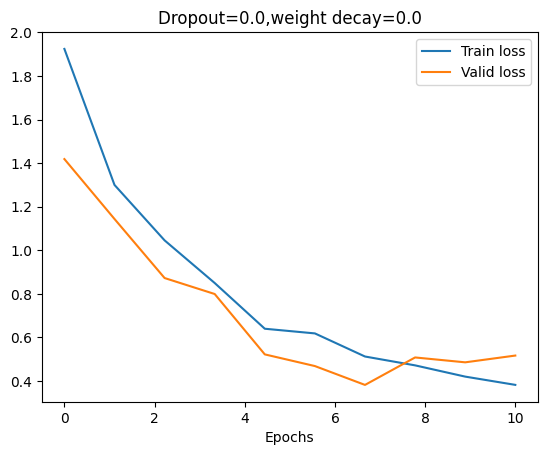

Test loss:0.5179718106985092, test acc: 0.77


In [97]:
output_dim = 10  # number of digits
# TODO: YOUR CODE HERE
# Play with variations of these hyper-parameters and report results
rnn_size = 64
num_layers = 2
bidirectional = False
dropout = 0.0
batch_size = 32
patience = 3
epochs = 15
lr = 1e-3
weight_decay = 0.0
checkpoint_loc = f'./models_dict/dr_{dropout}_wd_{weight_decay}.pth'  ### checkpoints save location

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(batch_size)
# TODO: YOUR CODE HERE
# Choose an appropriate loss function
criterion = nn.CrossEntropyLoss()

model,train_losses,valid_losses = train(bidirectional,dropout,weight_decay,train_dataloader, val_dataloader, criterion, checkpoint_loc)

## plot results
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),train_losses.values())
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),valid_losses.values())
plt.legend(['Train loss','Valid loss'])
plt.xlabel('Epochs')
plt.title(f'Dropout={dropout},weight decay={weight_decay}')
plt.show()

## using evaluation loop on test data
test_loss, test_pred, test_true = evaluation_loop(model, test_dataloader, criterion)
# TODO: YOUR CODE HERE
# print test loss and test accuracy
print(f'Test loss:{test_loss}, test acc: {accuracy_score(test_pred,test_true)}')


Training for dropout:0.4 and weight decay:0.1
Epoch 0: train loss = 1.621285014292773, valid loss = 1.2277001738548279, valid acc = 0.5518518518518518
Epoch 1: train loss = 1.0544890971744763, valid loss = 0.8819494492867413, valid acc = 0.6851851851851852
Epoch 2: train loss = 0.9120217552956413, valid loss = 0.701220806907205, valid acc = 0.7833333333333333
Epoch 3: train loss = 0.7249868249191957, valid loss = 0.629372437210644, valid acc = 0.774074074074074
Epoch 4: train loss = 0.7549944388515809, valid loss = 0.5583424918791827, valid acc = 0.8092592592592592
Epoch 5: train loss = 0.5418430845088819, valid loss = 0.4502542097778881, valid acc = 0.8351851851851851
Epoch 6: train loss = 0.6061347403070506, valid loss = 0.5040732008569381, valid acc = 0.8462962962962963
Epoch 7: train loss = 0.5907565070425763, valid loss = 0.38730937593123493, valid acc = 0.8833333333333333
Epoch 8: train loss = 0.4422745132709251, valid loss = 0.32164445519447327, valid acc = 0.8759259259259259
Ep

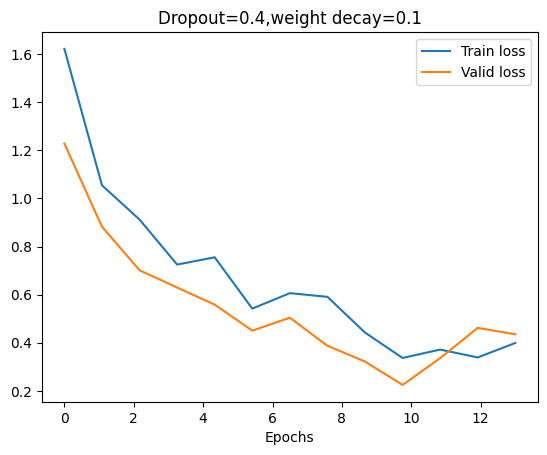

Test loss:0.44097517877817155, test acc: 0.8566666666666667


In [98]:
rnn_size = 64
num_layers = 2
bidirectional = False
dropout = 0.4
batch_size = 32
patience = 3
epochs = 15
lr = 1e-3
weight_decay = 0.1
checkpoint_loc = f'./models_dict/dr_{dropout}_wd_{weight_decay}.pth'  ### checkpoints save location

# TODO: YOUR CODE HERE
# Choose an appropriate loss function
criterion = nn.CrossEntropyLoss()
model,train_losses,valid_losses = train(bidirectional,dropout,weight_decay,train_dataloader, val_dataloader, criterion, checkpoint_loc)

## plot results
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),train_losses.values())
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),valid_losses.values())
plt.legend(['Train loss','Valid loss'])
plt.xlabel('Epochs')
plt.title(f'Dropout={dropout},weight decay={weight_decay}')
plt.show()

## using evaluation loop on test data
test_loss, test_pred, test_true = evaluation_loop(model, test_dataloader, criterion)
# TODO: YOUR CODE HERE
# print test loss and test accuracy
print(f'Test loss:{test_loss}, test acc: {accuracy_score(test_pred,test_true)}')

Training for dropout:0.4 and weight decay:0.1
Epoch 0: train loss = 1.3932508624651854, valid loss = 0.7540968621478361, valid acc = 0.762962962962963
Epoch 1: train loss = 0.7323372740955914, valid loss = 0.6491791939034182, valid acc = 0.762962962962963
Epoch 2: train loss = 0.4924205815529122, valid loss = 0.39823644652086143, valid acc = 0.8537037037037037
Epoch 3: train loss = 0.42130033912904125, valid loss = 0.45783528510261984, valid acc = 0.8407407407407408
Epoch 4: train loss = 0.44246699726756883, valid loss = 0.5372791448060203, valid acc = 0.7907407407407407
Epoch 5: train loss = 0.30720462781541485, valid loss = 0.2258049109402825, valid acc = 0.9222222222222223
Epoch 6: train loss = 0.29936102416147203, valid loss = 0.2813531243625809, valid acc = 0.9185185185185185
Epoch 7: train loss = 0.2393048496040351, valid loss = 0.2166694540749578, valid acc = 0.9351851851851852
Epoch 8: train loss = 0.24296392620924642, valid loss = 0.21004845464930816, valid acc = 0.91851851851

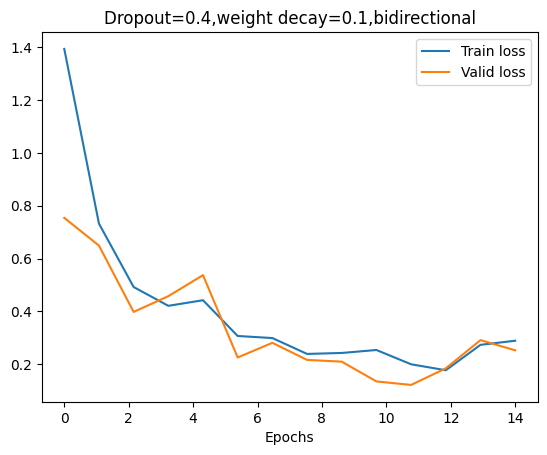

Test loss:0.12626381814479828, test acc: 0.96


In [99]:
rnn_size = 64
num_layers = 2
bidirectional = True
dropout = 0.4
batch_size = 32
patience = 3
epochs = 15
lr = 1e-3
weight_decay = 0.1
checkpoint_loc = f'./models_dict/dr_{dropout}_wd_{weight_decay}_bidirectional.pth'  ### checkpoints save location

# TODO: YOUR CODE HERE
# Choose an appropriate loss function
criterion = nn.CrossEntropyLoss()
model,train_losses,valid_losses = train(bidirectional,dropout,weight_decay,train_dataloader, val_dataloader, criterion, checkpoint_loc)

## plot results
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),train_losses.values())
plt.plot(np.linspace(0,len(train_losses),len(train_losses)),valid_losses.values())
plt.legend(['Train loss','Valid loss'])
plt.xlabel('Epochs')
plt.title(f'Dropout={dropout},weight decay={weight_decay},bidirectional')
plt.show()

## using evaluation loop on test data
test_loss, test_pred, test_true = evaluation_loop(model, test_dataloader, criterion)
# TODO: YOUR CODE HERE
# print test loss and test accuracy
print(f'Test loss:{test_loss}, test acc: {accuracy_score(test_pred,test_true)}')

Best model results:
Test loss:0.11292699500918388, test acc: 0.9766666666666667
Valid loss:0.12155778289717786, test acc: 0.9685185185185186
For test results:
Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 28  2  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  1  0  0 28  1  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  2  0 28  0]
 [ 0  1  0  0  0  0  0  0  0 29]]


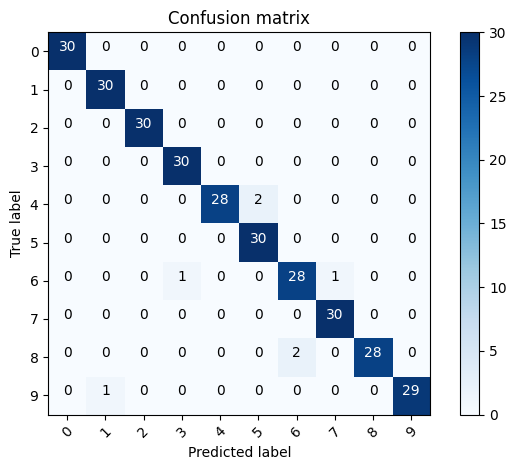

For valid results:
Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0  0  0]
 [ 0  0 54  0  0  0  0  0  0  0]
 [ 0  0  2 48  0  0  4  0  0  0]
 [ 0  1  0  0 52  0  1  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 53  0  1  0]
 [ 0  1  1  0  0  0  0 51  0  1]
 [ 0  0  0  0  0  0  1  0 53  0]
 [ 0  3  0  0  0  1  0  0  0 50]]


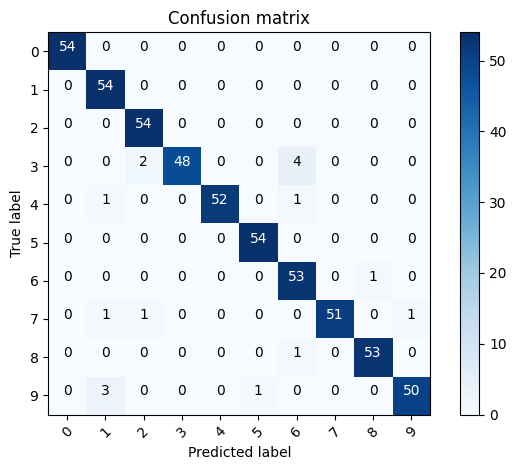

In [116]:
#### BEST MODEL so far: bidirectional, dropout = 0.4, weight decay>0
input_dim = train_dataloader.dataset.feats.shape[-1]

best_model = BasicLSTM(input_dim,rnn_size=64,output_dim=10,num_layers=2,bidirectional=True,dropout=0.4)

best_model.load_state_dict(torch.load('./models_dict/dr_0.4_wd_0.1_bidirectional.pth'))
best_model.eval()

## Get test and vali loss, and their predictions
test_loss, test_pred, test_true = evaluation_loop(best_model, test_dataloader, criterion)
valid_loss, y_pred, y_true = evaluation_loop(best_model, val_dataloader, criterion)

print('Best model results:')
print(f'Test loss:{test_loss}, test acc: {accuracy_score(test_pred,test_true)}')
print(f'Valid loss:{valid_loss}, test acc: {accuracy_score(y_pred,y_true)}')


valid_cm = confusion_matrix(y_true,y_pred)
test_cm = confusion_matrix(test_true,test_pred)
classes = [i for i in range(10)]
print('For test results:')
plot_confusion_matrix(test_cm,classes)
plt.show()
print('For valid results:')
plot_confusion_matrix(valid_cm,classes)
plt.show()